In [1]:
from __future__ import print_function
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import tables as tb
import random as rd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
montecarlo = tb.open_file('/home/jrenner/data/kr/kr_NEW_15bar_84000.h5', 'r')
tracks = montecarlo.root.MC.MCTracks
pmaps  = montecarlo.root.PMaps.PMaps

First, use tracks to get "true" coordinates for neural network

DNN label will be the average of these hit positions, weighted by their respective hit energys
[[ -73.73246002  142.96287537  508.25564575]
 [ -73.70937347  142.93251038  508.28378296]
 [ -73.68672943  142.92514038  508.28695679]
 [ -73.69263458  142.92468262  508.29208374]]


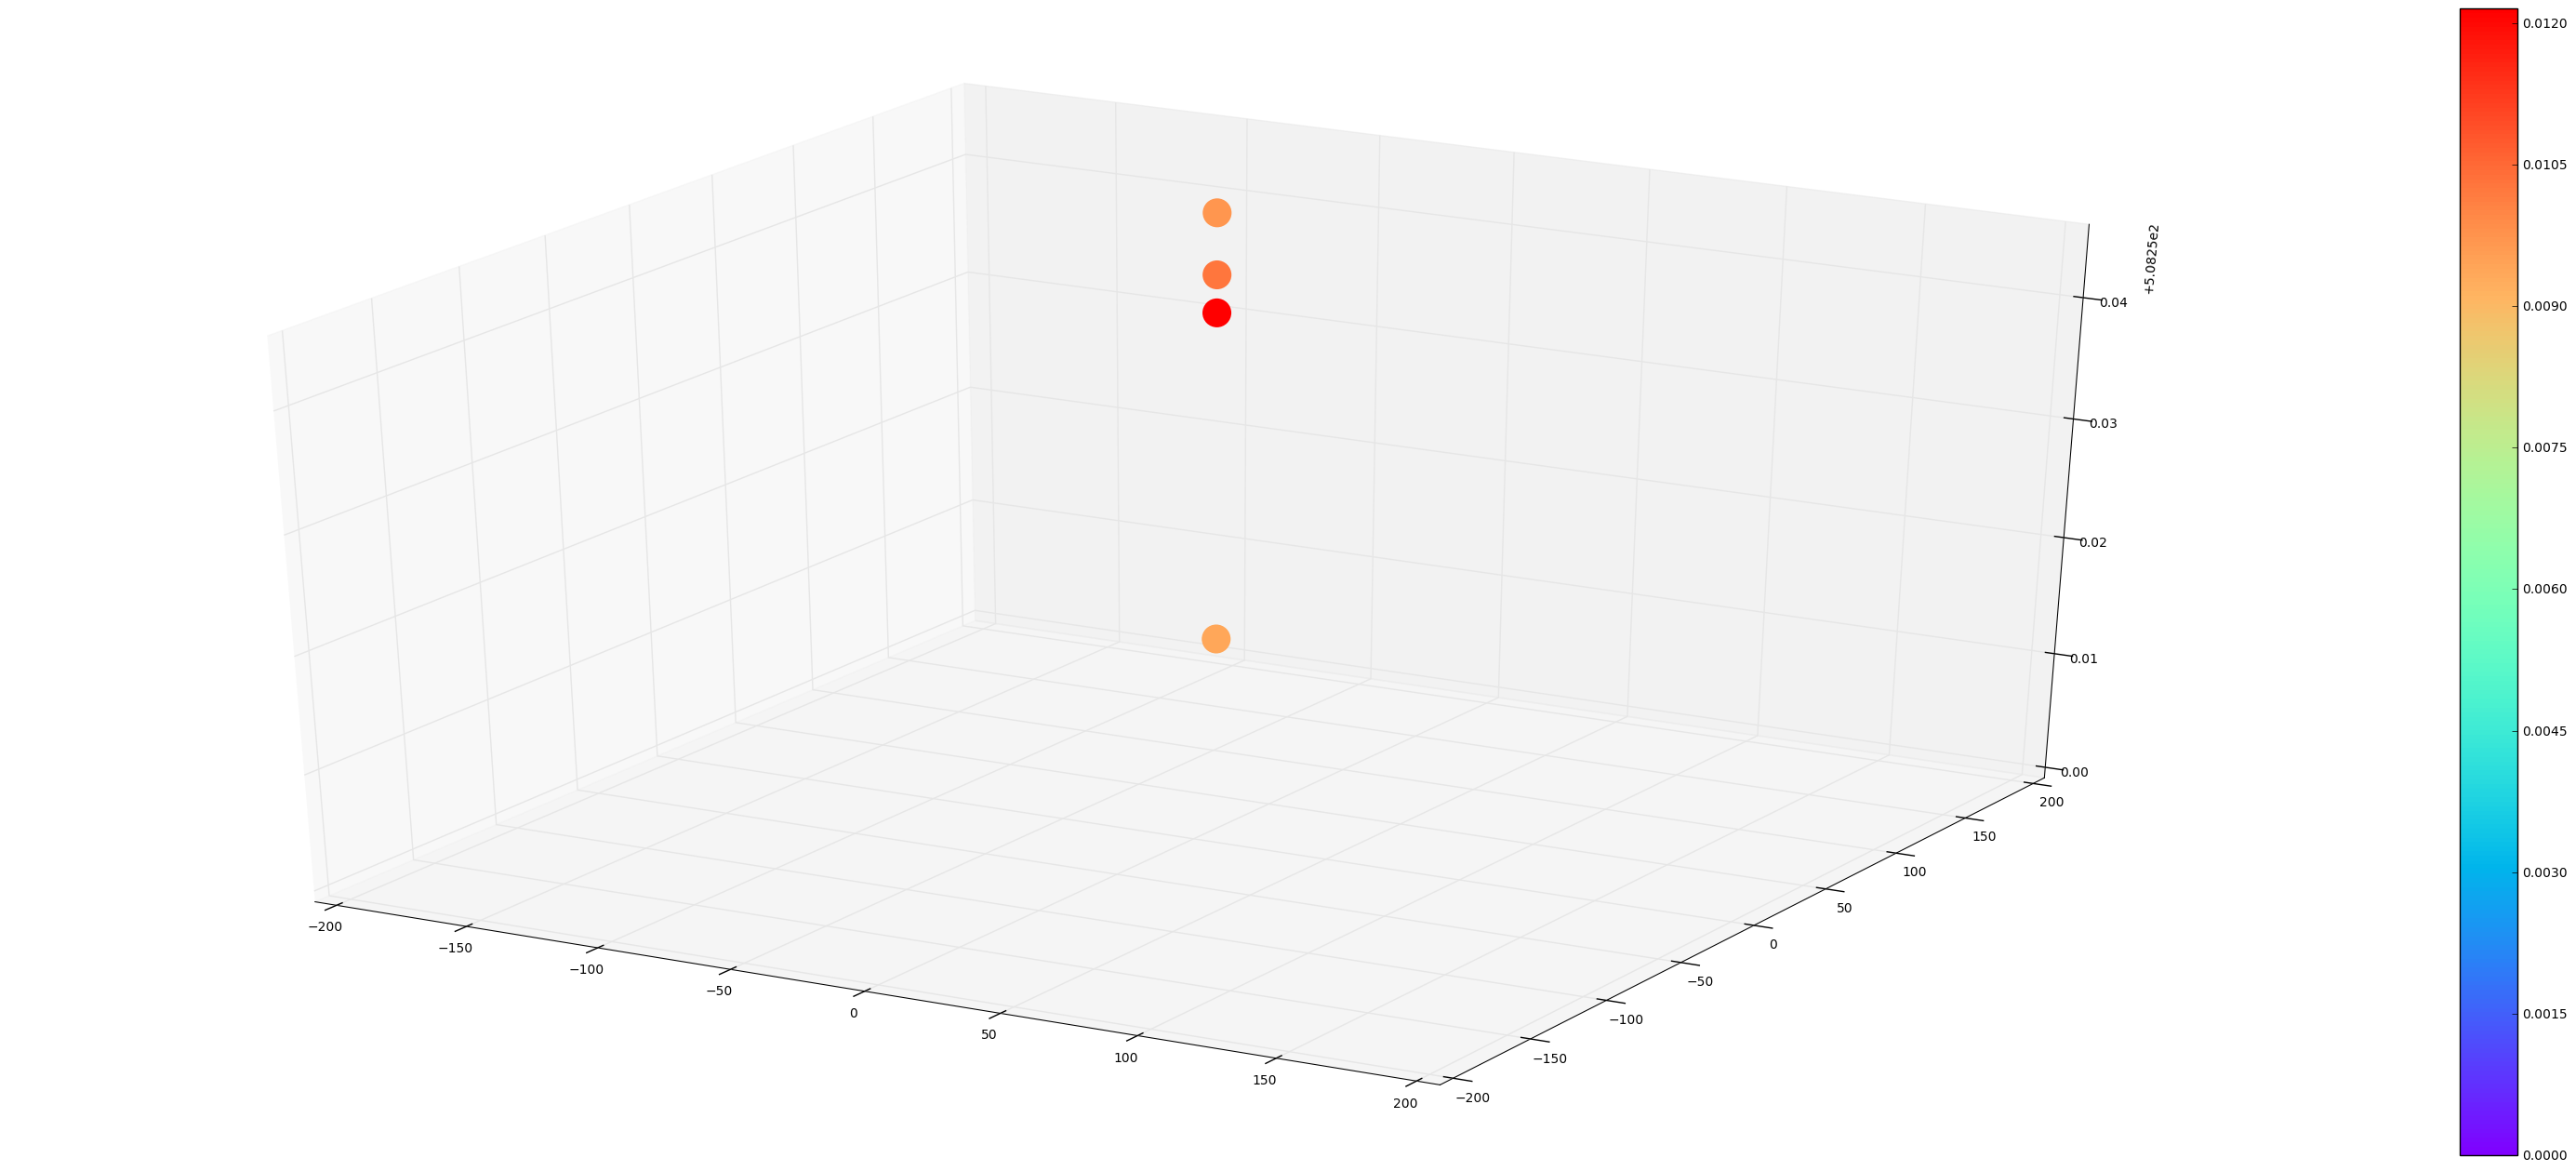

Notice the z (vertical) axis units are very small


In [3]:
event_indx = np.array(tracks[:]['event_indx'],dtype=np.int32)
hit_energy = np.array(tracks[:]['hit_energy'],dtype=np.float32)
hit_pos = np.array(tracks[:]['hit_position'],dtype=np.float32)
particle = np.array(tracks[:]['particle_name'])

# Plot an event
r = rd.sample(range(np.max(event_indx)),1)[0]
r = 10
hits = np.where(event_indx == r)[0]

print('DNN label will be the average of these hit positions, weighted by their respective hit energys')
print(hit_pos[hits])

fig = plt.figure()
fig.set_figheight(35.0)
fig.set_figwidth(40.0)
ax = fig.add_subplot(211, projection='3d')
s1=ax.scatter(hit_pos[hits,0], hit_pos[hits,1], hit_pos[hits,2], c=hit_energy[hits], cmap=plt.get_cmap('rainbow'),vmin=0,s=500,edgecolors='None')
s1.set_edgecolors = s1.set_facecolors = lambda *args:None;  # this disables automatic setting of alpha relative of distance to camera
cb1 = plt.colorbar(s1)
ax.set_xlim3d(-200, 200)
ax.set_ylim3d(-200, 200)
#ax.set_zlim3d(-0,500)
plt.grid(True)
plt.show()
print('Notice the z (vertical) axis units are very small')


In [4]:
# Loading particle names
lbl = np.zeros((np.max(event_indx) + 1, 3), dtype=np.float32)

disc = [] # list of event indices to discard

tot_energy = 0

# total energy for any event should be .041
print('---')
print(np.sum(hit_energy[np.where(event_indx == 10)[0]]))
print('---')

# Calculate "true" labels for dnn
for i, ev in enumerate(event_indx):
    
    # Discard events that have gammas with more than x energy
    
    # Discard events whose tracks are too far apart 
    
    # Discard events with incorrect total energy 
    
    # Compute average hit_pos, weighted by hit_energy
    lbl[ev] = lbl[ev] + hit_energy[i] * hit_pos[i]
    tot_energy += hit_energy[i]
    
    # Will throw index ev is last event number
    try:
        if ev + 1 == event_indx[i + 1]:
            lbl[ev] /= tot_energy
            tot_energy = 0
            
    except IndexError: 
        if ev == np.max(event_indx):
            lbl[ev] /= tot_energy
            tot_energy = -99999
            
        # This should not happen, so throw error
        else:  
            print(event_indx[i + 1])

---
0.0415433
---


Test that weighted average is being computed correctly

In [5]:
test_evt = 99
print(lbl[test_evt])
test_idxs = np.where(event_indx == test_evt)[0]
test_pos = np.array([0,0,0])
for e, pos in zip(hit_energy[test_idxs], hit_pos[test_idxs]):
    test_pos = test_pos + e * pos
test_pos = test_pos/np.sum(hit_energy[test_idxs])
print('=?')
print(test_pos)

[ 49.71268845  69.54194641  67.71473694]
=?
[ 49.71268816  69.54194712  67.71473646]


Now look at the p maps to create SiPM maps

In [6]:
event_indx = np.array(pmaps[:]['event_indx'])
signal_type = np.array(pmaps[:]['signal_type'])
id_list = np.array(pmaps[:]['ID_list'])
amp_list = np.array(pmaps[:]['amp_list'])
montecarlo.close()

Create a single SiPM map for each event

In [7]:
f_ids = tb.open_file('ReproducedFull.h5')
s_ids = np.array(f_ids.root.Sensors.XY)
f_ids.close()

# Construct a dictionary that will map sensor id to a x,y coord pair
id_to_coords = {}
for ID, x, y in zip(s_ids[12:, 0], s_ids[12:, 1], s_ids[12:, 2]):
    id_to_coords[np.int32(ID)] = np.array([-x, y])  # -x b/c old IDs!
    
# Populate SiPM maps for each event
maps = np.zeros((np.max(event_indx) + 1, 48, 48), dtype=np.float32)
for ev, IDs, amps in zip(event_indx, id_list, amp_list):
    for ID, amp in zip(IDs, amps):
        if amp == 0.00:
            break
        else:       
            [i,j] = (id_to_coords[ID] + 235) / 10
            maps[ev, np.int8(i), np.int8(j)] += amp
                

Plot an event

[-85 135]
[-85 145]
[-85 155]
[-75 135]
[-75 145]
[-75 155]
[-65 135]
[-65 145]
-73.7051 142.936


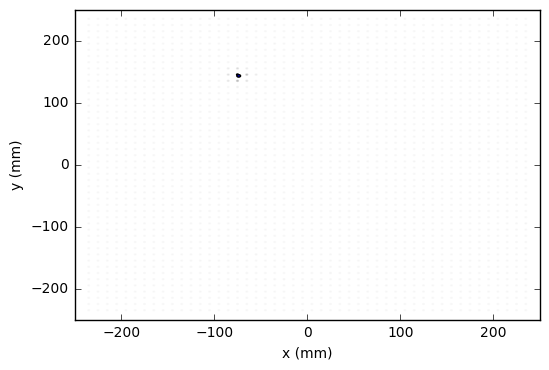

In [8]:
pevt = np.random.randint(np.max(event_indx))
pevt = 10
fig = plt.figure();
ax1 = fig.add_subplot(111);
ax1.axis([-250, 250, -250, 250]);

xarr = maps[pevt]
yarr = lbl[pevt,:2]

# Create circles and plot them according to the probabilities.
probs = (xarr - np.min(xarr))
probs /= np.max(probs)
    
for i in range(48):
    for j in range(48):
        if probs[i,j] > 0.02: print(np.array([i,j])*10 - 235) 
        
        r = Ellipse(xy=(i * 10 - 235, j * 10 - 235), width=2., height=2.);
        r.set_facecolor('0');
        r.set_alpha(0.02 + 0.98 * probs[i, j]);
        ax1.add_artist(r);

# Place a large blue circle for actual EL points.
xpt = yarr[0]
ypt = yarr[1]
mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
mrk.set_facecolor('b');
ax1.add_artist(mrk);
print(xpt,ypt)

# Show the plot.
plt.xlabel("x (mm)");
plt.ylabel("y (mm)");
plt.show()

Save the data!

In [9]:
f = tb.open_file('NEW_kr_84k_Nodiff.h', 'w')
filters = tb.Filters(complib='blosc', complevel=9, shuffle=False)

atom    = tb.Atom.from_dtype(maps.dtype)
tmaps   = f.create_earray(f.root, 'maps',   atom, (0, 48, 48), filters=filters) 

atom    = tb.Atom.from_dtype(lbl.dtype)
tcoords = f.create_earray(f.root, 'coords', atom, (0, 3), filters=filters)

for i in range(len(lbl)):
    tmaps.append([maps[i]])
    tcoords.append([lbl[i]])
    
print(f)
f.close()

NEW_kr_84k_Nodiff.h (File) ''
Last modif.: 'Mon Nov 14 17:58:44 2016'
Object Tree: 
/ (RootGroup) ''
/coords (EArray(84000, 3), blosc(9)) ''
/maps (EArray(84000, 48, 48), blosc(9)) ''

